In [1]:
%matplotlib widget

import logging
import numpy as np
import matplotlib.pyplot as plt
import climada
import cartopy
import pickle
import warnings # To hide the warnings

# this is to hide warnings
logging.getLogger("climada").setLevel(logging.CRITICAL)
logging.getLogger(__name__).setLevel(logging.ERROR)

logging.basicConfig(level=logging.CRITICAL)

# Disable all logging
logging.disable(logging.CRITICAL)
warnings.simplefilter("ignore")

ERROR 1: PROJ: proj_create_from_database: Open of /home/arthur/miniforge3/envs/climada_env/share/proj failed
/home/arthur/miniforge3/envs/climada_env/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:15: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(


## Pareto distribution to model the intensity of granular events

In the case of granular event data (as opposed to annual maxima data), we saw that the general formula for the return period for an intensity $x$ is given by,

\begin{equation}
    T(x) = \frac{1}{\lambda (1 - F_X(x))},
\end{equation}

where,
1. $\lambda$ is the frequency of events, that is to say the number of events per year. E.g. if our record contains 10 events over 100 years, this corresponds to a frequency of
   $\lambda=0.1$ event per year.
3.  $F_X(x)$ is the Cumulative Distribution Function of the intensity of the events.

In the parametric case, we need a parametric family of probability distribution, with cumulative distribution function $F_X(x; \boldsymbol{\theta})$ where $\boldsymbol{\theta}$ is a parameter or a parameter vectors (if there are several parameters). While for annual maxima data we used the *Generalized Extreme Value distribution* (of which the Frechet distribution is a particular case), for granular event data we can instead use the *Pareto distribution*.

<div class="alert alert-block alert-success">
The Pareto distribution has probability density function,

\begin{equation}
    f_X(x; b) = \frac{bx_0^b}{x^{b + 1}}, \quad x\geq x_0, b>0.
\end{equation}

The intensity $x_0$ corresponds to the threshold intensity used for the definition of a natural disaster. 
</div>

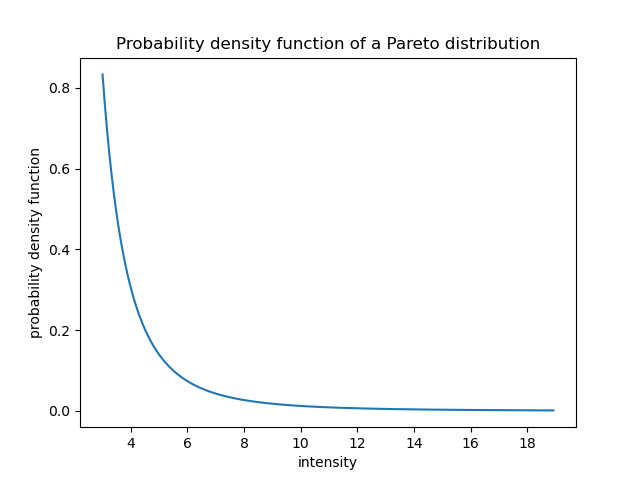

In [2]:
from scipy.stats import pareto

distribution = pareto(b=2.5, scale=3)
xmin, xmax = distribution.ppf(0.), distribution.ppf(0.99)
xs = np.linspace(xmin, xmax, 1000)

plt.figure()
plt.plot(xs, distribution.pdf(xs))
plt.xlabel('intensity')
plt.ylabel('probability density function')
plt.title('Probability density function of a Pareto distribution');

We can estimate the parameters of a Pareto distribution from data using Maximum Likelihood estimation.

In [3]:
from scipy.optimize import minimize

def func(x):
    b, sigma = x
    return - np.sum(np.log(b) + b * np.log(sigma) - (b + 1) * np.log(data))

#minimize(func, x0=[1.5, 1.5], bounds=[(1, 10), (1, np.min(data))], options=dict(ftol=1e-50))

## Monte Carlo simulations of natural disasters

Often, the situation occurs that we do not have enough events in our record to produce robust estimates of impact. A common approach to this issue is to use historical data to generate new *probable* events. These simulations are commonly called *Monte Carlo simulations*, or synthetic data.

The general idea is as follows: 

1. We start with $N$ real events from our record
2. For each event $j=1, \ldots, N$, we simulate $M$ Monte Carlo events

We need to be careful to adapt the frequency $\lambda$ in the general formula. How do you think we should adapt the frequency of each event in the dataset?

Similarly, the formula for the average annual impact needs to account for this.

## Application to Tropical Cyclones with Climada

Climada makes it easy to synthesize virtual tracks from a historical track. For instance, in the code below we load the track of the Tropical Cyclone Irma (2017) and synthesize 5 perturbed trajectories. Note that the intensity of the perturbed trajectories is set to decay when the tropical cyclones hits land.

```python
from climada.hazard import TCTracks

tr_irma = TCTracks.from_ibtracs_netcdf(
    provider="usa", storm_id="2017242N16333"
)  # IRMA 2017
ax = tr_irma.plot()
ax.set_title("IRMA")  # set title

tr_irma.equal_timestep()
tr_irma.calc_perturbed_trajectories(nb_synth_tracks=5)
tr_irma.plot();
```

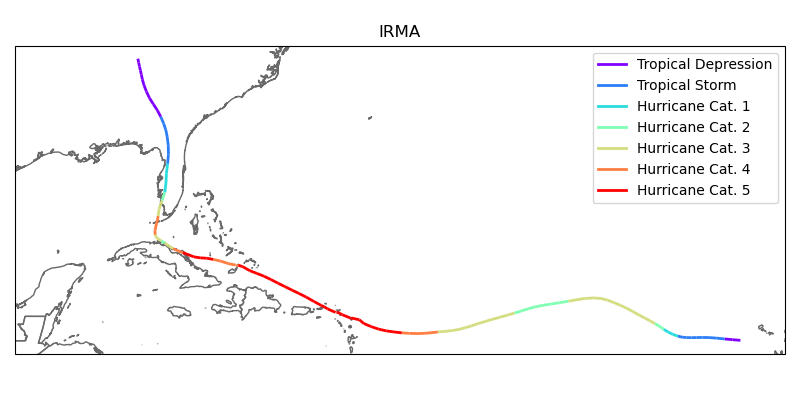

In [4]:
from utils import get_projection

from climada.hazard import TCTracks
tr_irma = TCTracks.from_ibtracs_netcdf(
    provider="usa", storm_id="2017242N16333"
)  # IRMA 2017

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(projection=get_projection())
tr_irma.plot(axis=ax)
ax.set_title("IRMA");  # set title

Text(0.5, 1.0, 'IRMA and 5 synthetic tracks')

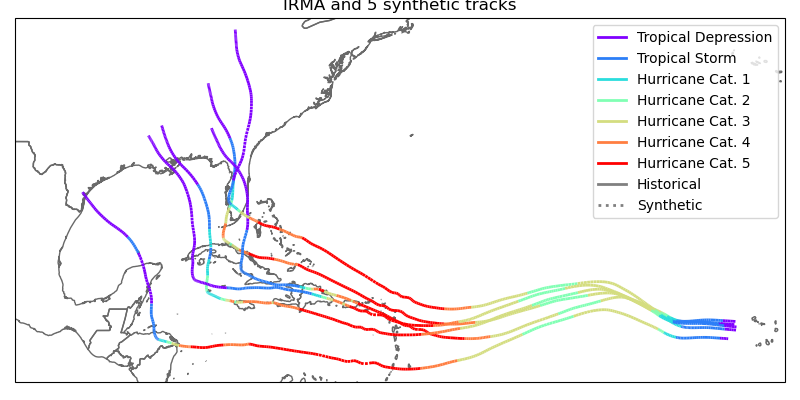

In [5]:
try:
    with open('pickles/slides6/tr_irma.pkl', 'rb') as f:
        tr_irma = pickle.load(f)
except:
    tr_irma.equal_timestep()
    tr_irma.calc_perturbed_trajectories(nb_synth_tracks=5)

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(projection=get_projection())
tr_irma.plot(axis=ax)
ax.set_title("IRMA and 5 synthetic tracks")

In [6]:
with open('pickles/slides6/tr_irma.pkl', 'wb') as f:
    pickle.dump(tr_irma, f)

The way we now define a Hazard of type TropCyclone does not differ from what we saw before:
1. We define a set lof centroids / locations
2. We use the method `from_track` of the class TropCyclone and pass it `tr_irma`, which contains both the original track and the synthesized tracks.

```python
from climada.hazard import Centroids, TropCyclone

# construct centroids
min_lat, max_lat, min_lon, max_lon = 16, 21, -72, -61
cent = Centroids.from_pnt_bounds((min_lon, min_lat, max_lon, max_lat), res=0.5)
cent.plot()

# construct tropical cyclones
tc_irma = TropCyclone.from_tracks(tr_irma, centroids=cent)
```

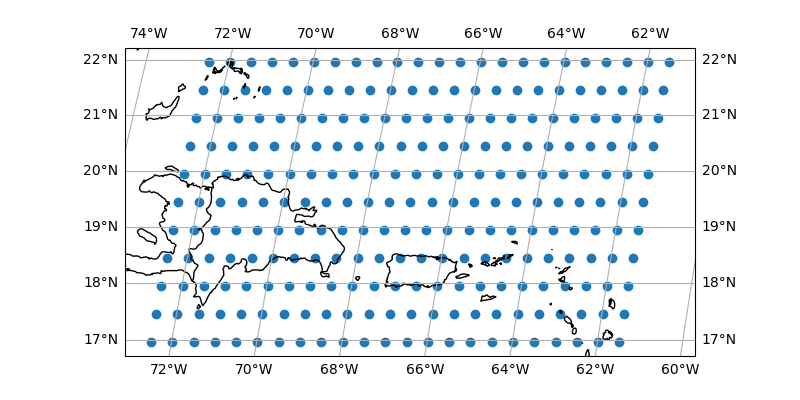

In [7]:
from climada.hazard import Centroids, TropCyclone

# construct centroids
min_lat, max_lat, min_lon, max_lon = 16.99375, 21.95625, -72.48125, -61.66875
cent = Centroids.from_pnt_bounds((min_lon, min_lat, max_lon, max_lat), res=0.5)

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(projection=get_projection())
cent.plot(axis=ax)

# construct tropical cyclones
tc_irma = TropCyclone.from_tracks(tr_irma, centroids=cent)

<GeoAxes: title={'center': 'TC max intensity at each point'}>

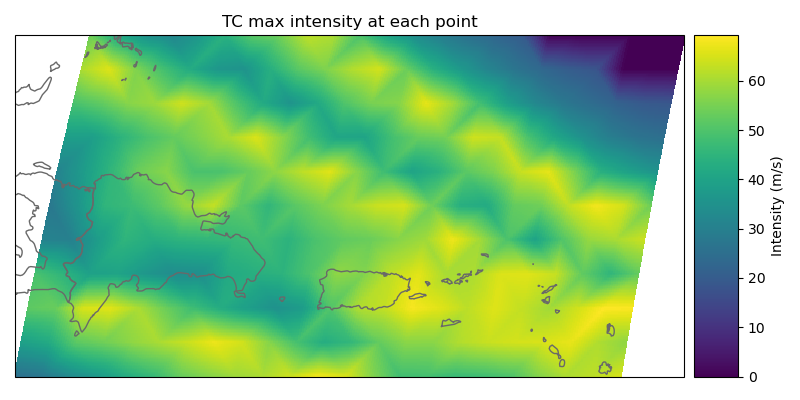

In [8]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(projection=get_projection())
tc_irma.plot_intensity(0, axis=ax)

Now if we check the frequency array of tc_irma (which is of type TropCyclone, a class that inherits from the general class Hazard), we see that
we get $\frac{1}{5 + 1}$ (5 synthetic Tropical Cyclone tracks, one historic):

```python
print('Frequency of events: ', tc_irma.frequency)
```

In [12]:
print('Frequency of events: ', tc_irma.frequency)

Frequency of events:  [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]


## Looking at other types of risks

Until now, all our examples were concerned with tropical cyclones. However, as mentioned in the first lecture there are many other types of Climate Risks. The mathematical framework remains the same. The differences are:
1. Hazard specification from historical data (i.e. we need the intensities on a set of centroids)
2. Impact function specification

### Tropical Cyclone Rain

/home/arthur/miniforge3/envs/climada_env/lib/python3.11/site-packages/climada/hazard/tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:
/home/arthur/miniforge3/envs/climada_env/lib/python3.11/site-packages/climada/hazard/tc_tracks.py:1511: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "_one_interp_data" failed type inference due to: non-precise type pyobject
During: typing of argument at /home/arthur/miniforge3/envs/climada_env/lib/python3.11/site-packages/climada/hazard/tc_tracks.py (1545)

File "../../miniforge3/envs/climada_env/lib/python3.11/site-packages/climada/hazard/tc_tracks.py", line 1545:
    def _one_interp_data(track, time_step_h, land_geom=None):
        <source elided>



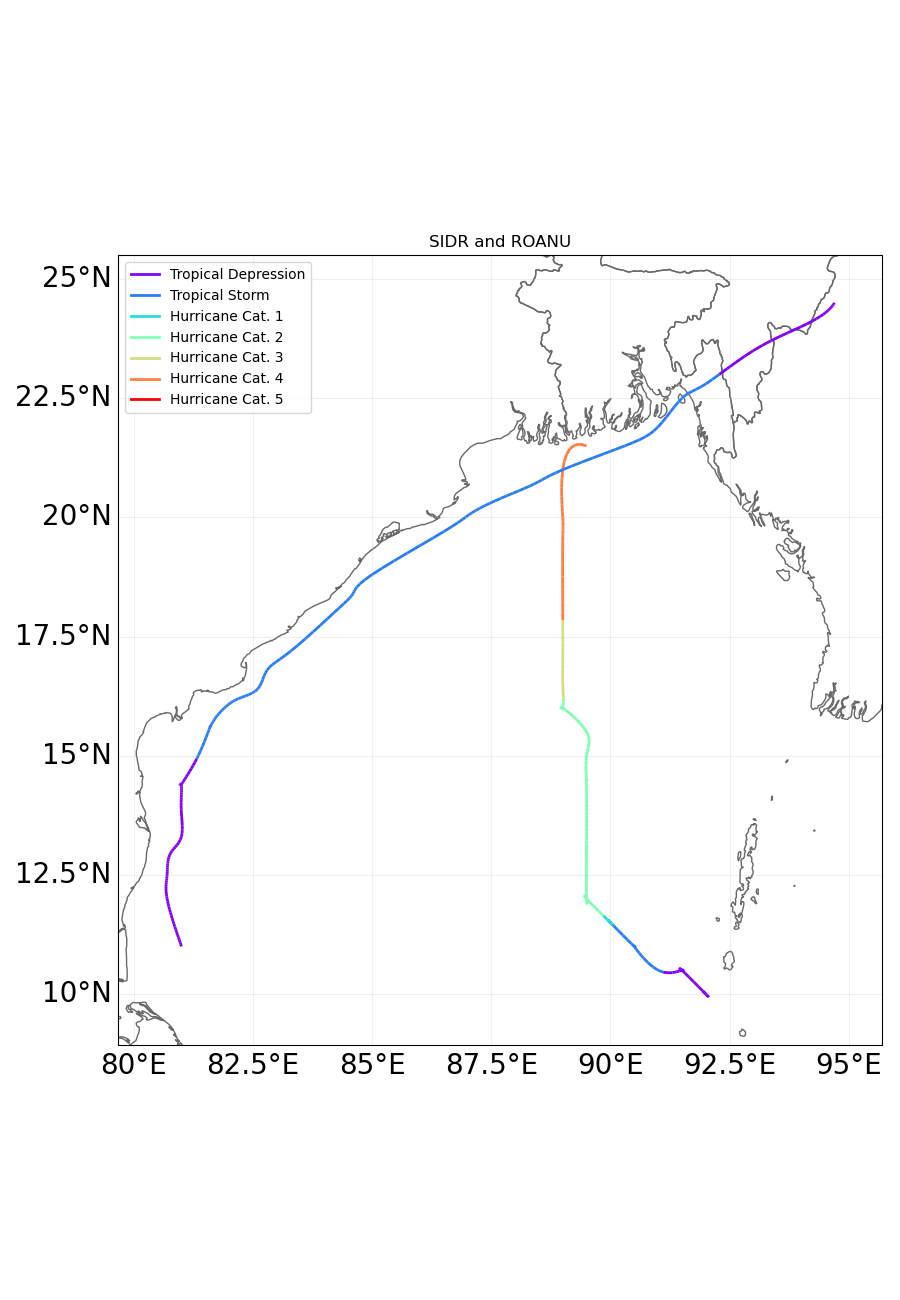

In [122]:
from climada.hazard import TCTracks

tracks = TCTracks.from_ibtracs_netcdf(
    # SIDR 2007 and ROANU 2016
    storm_id=['2007314N10093', '2016138N10081'],
)
tracks.equal_timestep(0.5)

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(projection=get_projection())
tracks.plot(axis=ax)
ax.get_legend()._loc = 2
ax.set_title('SIDR and ROANU');

We define centroids just like we are used to:

```python
from climada.hazard import Centroids

# define centroids and restrict to points on land
min_lat, max_lat, min_lon, max_lon = 21.0, 24.5, 88.5, 92.5
cent_bang = Centroids.from_pnt_bounds((min_lon, min_lat, max_lon, max_lat), res=0.015)
```

In [123]:
from climada.hazard import Centroids

# define centroids and restrict to points on land
min_lat, max_lat, min_lon, max_lon = 21.0, 24.5, 88.5, 92.5
cent_bang = Centroids.from_pnt_bounds((min_lon, min_lat, max_lon, max_lat), res=0.015)

We use the class TCRain, and its method `from_tracks`, to compute the hazard due to precipitation.

```python
from climada_petals.hazard import TCRain

tr_bang = TCRain.from_tracks(tracks, cent_bang, model="R-CLIPER")
ax = tr_bang.plot_intensity(2)
ax.set_title('Rain ROANU 2016 (from R-CLIPER)');
```

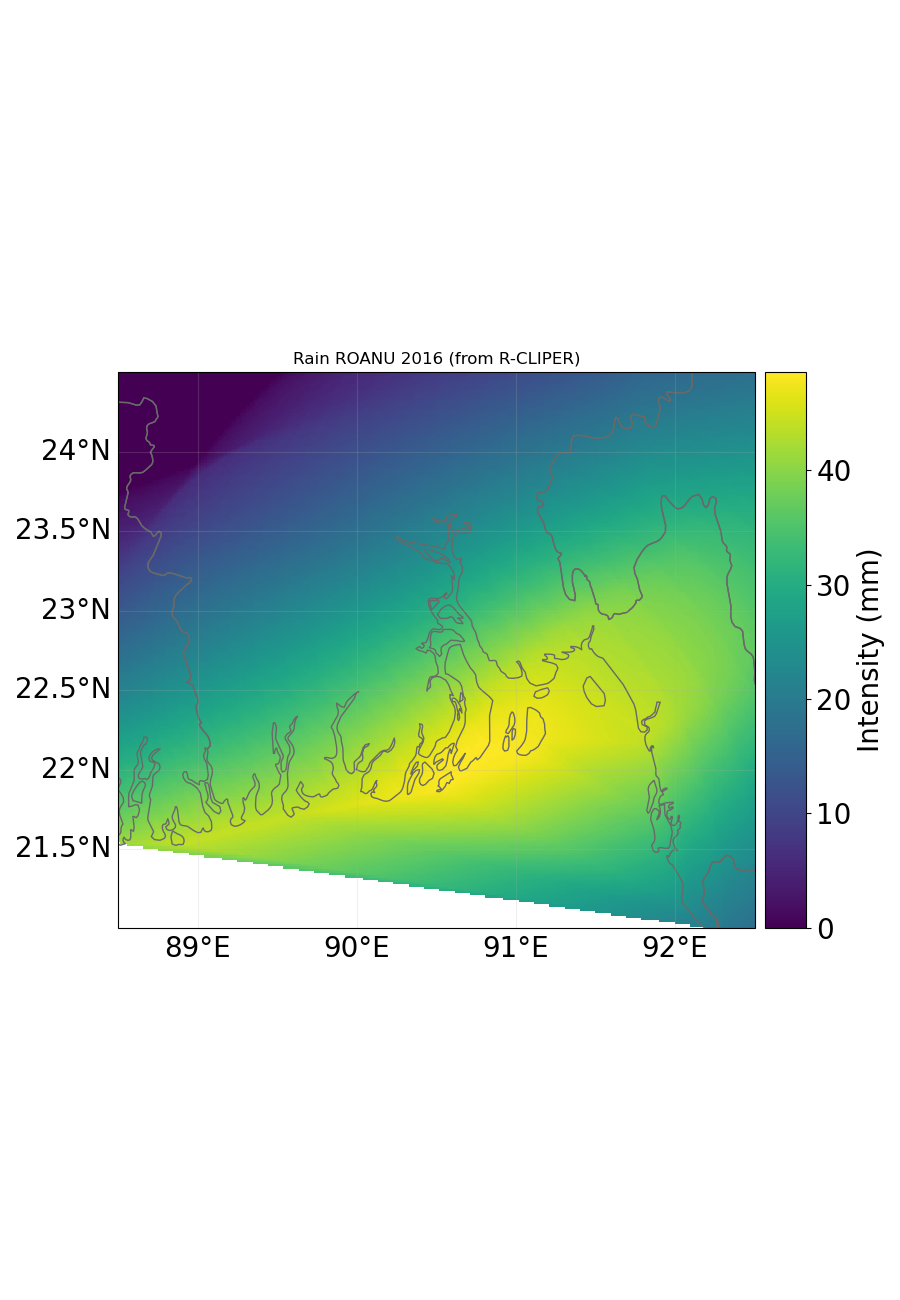

In [185]:
from climada_petals.hazard import TCRain

try:
    with open('pickles/slides6/tr_bang.pkl', 'rb') as f:
        tr_bang = pickle.load(f)
except:
    tr_bang = TCRain.from_tracks(tracks, cent_bang, model="R-CLIPER")

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(projection=get_projection())
tr_bang.plot_intensity(2, axis=ax)
ax.set_title('Rain ROANU 2016 (from R-CLIPER)');

In [184]:
with open('pickles/slides6/tr_bang.pkl', 'wb') as f:
    pickle.dump(tr_bang, f)

### Wildfire

The data used to define hazards for wildfires consists in satellite measurements of ground temperature. These data can be downloaded online. For instance, below we plot the data for one wildfire event. In Climada, we can process these data into objects of type hazard using the `WildFire` class from climada_petals.

```python
import os
import pandas as pd
from climada_petals.hazard import WildFire


# Read data
d_path = "/media/arthur/DATA/climada_data/DL_FIRE_M-C61_587390/fire_archive_M-C61_587390.csv"
firms = pd.read_csv(d_path)

# set up wildfire hazard
wf_pt = WildFire()
wf_pt.set_hist_fire_FIRMS(firms, centr_res_factor=1./2.5) # we decrease the hazard resolution to 2.5 km

# plot the maximum intensity of all fires at each centroid
wf_pt.plot_intensity(event=10);
```

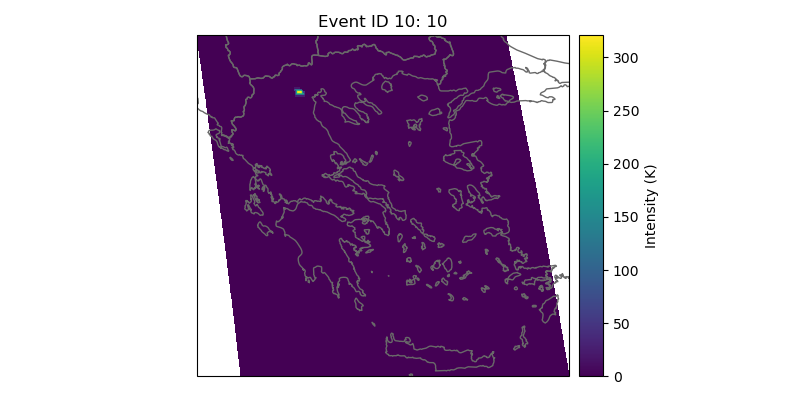

In [14]:
# Fires in Greece
import pickle
import os
import pandas as pd

from climada.util.constants import DEMO_DIR
from climada_petals.hazard import WildFire



try:
    raise ValueError()
    with open('pickles/slides6/wf_pt.pkl', 'rb') as f:
        wf_pt = pickle.load(f)
except:
    # Data downloaded for MODIS
    d_path = os.path.join(DEMO_DIR, "/media/arthur/DATA/climada_data/DL_FIRE_M-C61_587390/fire_archive_M-C61_587390.csv")
    
    # read data
    firms = pd.read_csv(d_path) # FIRMS data as pandas dataframe
    
    # set up wildfire
    wf_pt = WildFire()
    wf_pt.set_hist_fire_FIRMS(firms, centr_res_factor=1/10) # we decrease the hazard resolution to 2.5 km

# plot the maximum intensity of all fires at each centroid
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(projection=get_projection())
wf_pt.plot_intensity(event=10, axis=ax);

In [10]:
import pickle
with open('./pickles/slides6/wf_pt.pkl', 'wb') as f:
    pickle.dump(wf_pt, f)

Rather than looking at individual fires, we can also look at fires over whole years using the method
`set_hist_fire_seasons_FIRMS`.

Events are now named according to their event year: ['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']


<GeoAxes: title={'center': 'Event ID 2: 2001'}>

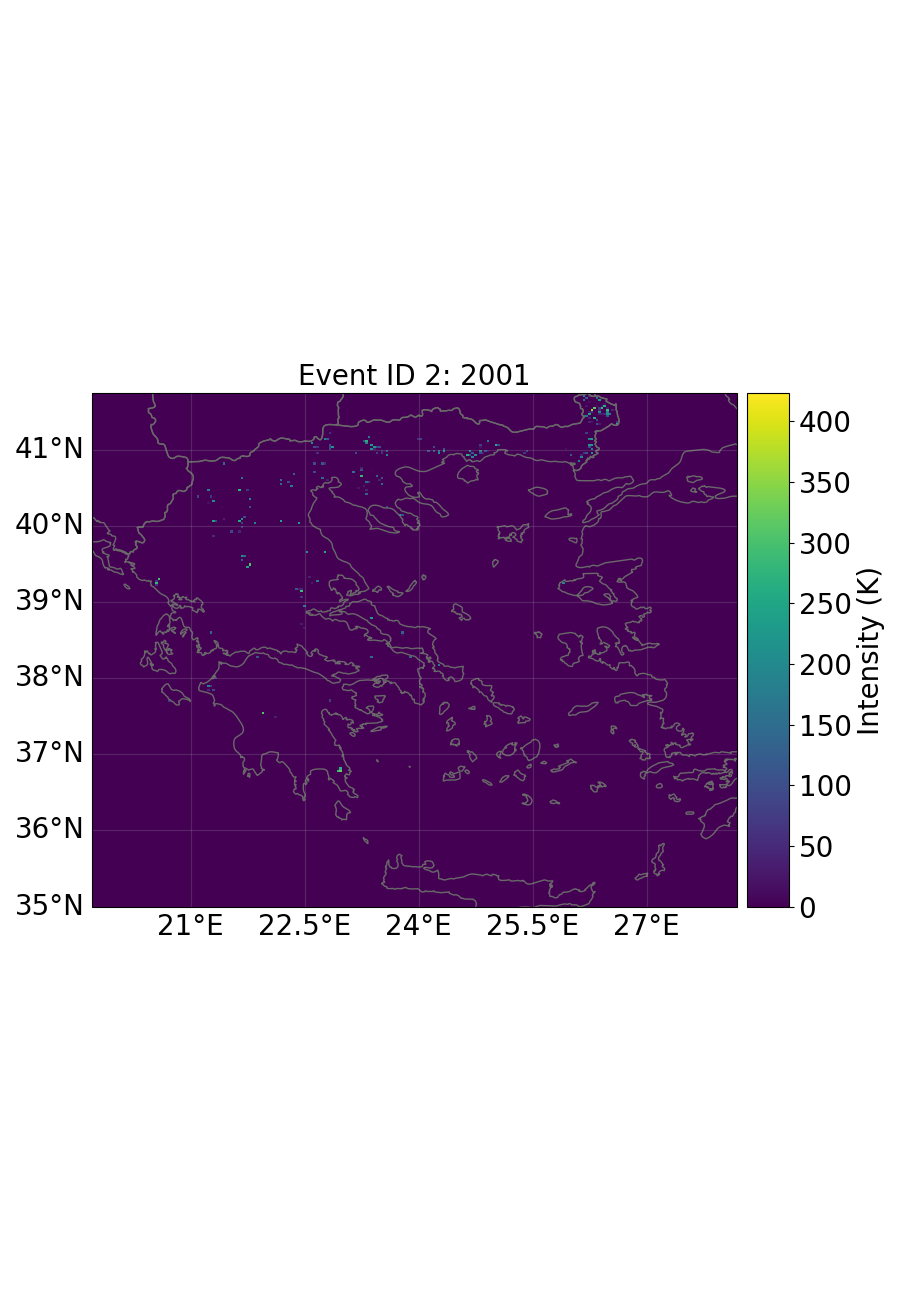

In [181]:
firms_seasons = pd.read_csv(os.path.join(DEMO_DIR, "/media/arthur/DATA/climada_data/DL_FIRE_M-C61_587390/fire_archive_M-C61_587390.csv"))
firms_seasons = firms_seasons[firms_seasons['latitude']>35.]
firms_seasons = firms_seasons[firms_seasons['longitude']>-12.]

try:
    with open('pickles/slides6/wf_years.pkl', 'rb') as f:
        wf_years = pickle.load(f)
except:
    wf_years = WildFire()
    wf_years.set_hist_fire_seasons_FIRMS(firms_seasons, centr_res_factor=1/1.) # we use MODIS data resolution (1 km)


# plot the three fire seasons (2016, 2017, 2018)
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(projection=get_projection())
wf_years.plot_intensity(2, axis=ax)

In [180]:
with open('./pickles/slides6/wf_years.pkl', 'wb') as f:
    pickle.dump(wf_years, f)